# Population effects of $I_A$ in a toy model

$I_A$ increases latency and decreases population firing rate. Shown in fig. 2.

In [1]:
from common import colors, sbarlw, savefig

In [2]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/efharkin/projects/raphegif/raphegif


In [3]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
from ezephys import pltools

from grr import IAmod

In [4]:
Vin = np.empty((10000, 600))
Vin[:1000, :] = 0
Vin[1000:, :] = 60.2

models = {
    'LIF': IAmod.IAmod(0., 1., 4., 1.),
    'LIF + $I_A$ (RT)': IAmod.IAmod(11.4, 0.545, 4., 1.),
    'LIF + $I_A$ (29C-30C)': IAmod.IAmod(4.54, 0.941, 4., 1.)
}
models['LIF + $I_A$ (29C-30C)'].m_A = 1849.
models['LIF + $I_A$ (29C-30C)'].m_Vhalf = 92.77
models['LIF + $I_A$ (29C-30C)'].m_k = 0.06646
models['LIF + $I_A$ (29C-30C)'].h_A = 1.008
models['LIF + $I_A$ (29C-30C)'].h_Vhalf = -54.93
models['LIF + $I_A$ (29C-30C)'].h_k = -0.1667

for model in models.values():
    model.vreset = -60.

simulations = {
    k: IAmod.Simulation(models[k], models[k].El, Vin)
    for k in models.keys()
}

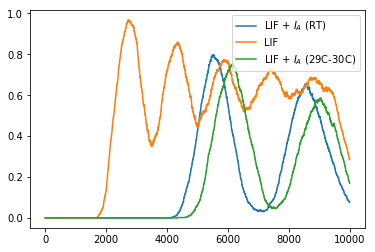

In [5]:
for k in models.keys():
    plt.plot(simulations[k].PSTH(1.), label=k)
plt.legend()

Saving svg
Saving png
Done!


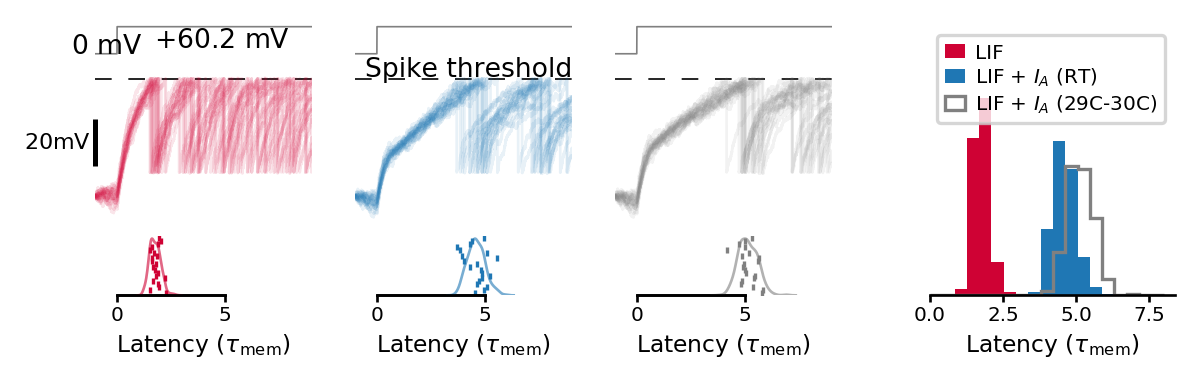

In [6]:
neurons_to_show = 20
style = {
    'LIF': {'color': colors['4AP'], 'linestyle': '-'},
    'LIF + $I_A$ (RT)': {'color': colors['ser'], 'linestyle': '-'},
    'LIF + $I_A$ (29C-30C)': {'color': 'gray', 'linestyle': '-'},
}

plt.style.use('./figs/scripts/publication_figure_style.dms')

IMG_PATH = os.getenv('IMG_PATH')

spec_outer = gs.GridSpec(
    1,
    2,
    hspace=0.5,
    left=0.05,
    right=0.95,
    top=0.95,
    bottom=0.2,
    width_ratios=[3, 1],
)
spec_traces = gs.GridSpecFromSubplotSpec(
    3, 3, spec_outer[0, 0], height_ratios=[0.2, 1, 0.4]
)

plt.figure(figsize = (5, 1.5))

for i, k in enumerate(['LIF', 'LIF + $I_A$ (RT)', 'LIF + $I_A$ (29C-30C)']):
    in_ax = plt.subplot(spec_traces[0, i])
    plt.plot(simulations[k].t_vec, Vin[:, 0], color='gray', lw=0.5)
    if i == 0:
        plt.annotate('$0$ mV', (0.5, 2), ha='center')
        plt.annotate('$+60.2$ mV', (9, 58), ha='right', va='top')
        input_ylim = plt.ylim()
    else:
        plt.ylim(input_ylim)
    plt.xlim(simulations[k].t_vec[0], simulations[k].t_vec[-1])
    pltools.hide_border()
    pltools.hide_ticks()

    vtrace_ax = plt.subplot(spec_traces[1, i], sharex=in_ax)
    plt.axhline(-20, color='k', lw=0.5, ls='--', dashes=(10, 10))
    plt.plot(
        simulations[k].t_vec,
        simulations[k].V[:, :neurons_to_show],
        alpha=0.1,
        **style[k]
    )
    plt.xlim(simulations[k].t_vec[0], simulations[k].t_vec[-1])
    if i == 0:
        pltools.add_scalebar(
            y_units='mV',
            y_size=20,
            omit_x=True,
            anchor=(0, 0.3),
            linewidth=sbarlw,
        )
        v_ylim = plt.ylim()
    else:
        if i == 1:
            plt.annotate('Spike threshold', (10, -19), ha='right')

        pltools.hide_border('a')
        pltools.hide_ticks()
        plt.ylim(v_ylim)

    raster_ax = plt.subplot(spec_traces[2, i])
    density_ax = raster_ax.twinx()
    sns.kdeplot(
        (
            simulations[k].get_spk_latencies()[
                ~np.isnan(simulations[k].get_spk_latencies())
            ]
            - 1
        ).flatten(),
        alpha=0.6,
        ax=density_ax,
        **style[k]
    )
    for j in range(neurons_to_show):
        first_spk = 1e-3 * np.min(np.where(simulations[k].spks[:, j])[0])
        raster_ax.plot(
            first_spk - 1, j, '|', color=style[k]['color'], markersize=2
        )
    raster_ax.set_xlim(
        simulations[k].t_vec[0] - 1, simulations[k].t_vec[-1] - 1
    )
    raster_ax.set_xlabel('Latency ($\\tau_{{\mathrm{{mem}}}}$)')
    raster_ax.set_yticks([])
    density_ax.set_yticks([])
    pltools.hide_border('trl', trim=True, ax=raster_ax)
    pltools.hide_border('trl', trim=True, ax=density_ax)

bins = np.linspace(0, 8, 20)
plt.subplot(spec_outer[0, 1])
plt.hist(
    simulations['LIF'].get_spk_latencies()[
        ~np.isnan(simulations['LIF'].get_spk_latencies())
    ]
    - 1,
    edgecolor='none',
    facecolor=style['LIF']['color'],
    bins=bins,
    label='LIF',
)
plt.hist(
    simulations['LIF + $I_A$ (RT)'].get_spk_latencies()[
        ~np.isnan(simulations['LIF + $I_A$ (RT)'].get_spk_latencies())
    ]
    - 1,
    edgecolor='none',
    facecolor=style['LIF + $I_A$ (RT)']['color'],
    bins=bins,
    label='LIF + $I_A$ (RT)',
)
plt.hist(
    simulations['LIF + $I_A$ (29C-30C)'].get_spk_latencies()[
        ~np.isnan(simulations['LIF + $I_A$ (29C-30C)'].get_spk_latencies())
    ]
    - 1,
    edgecolor=style['LIF + $I_A$ (29C-30C)']['color'],
    histtype='step',
    bins=bins,
    label='LIF + $I_A$ (29C-30C)',
)
plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1] * 1.3)
plt.xlabel('Latency ($\\tau_{{\mathrm{{mem}}}}$)')
pltools.hide_border('ltr')
plt.yticks([])
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))


if IMG_PATH is not None:
    savefig(IMG_PATH + 'IA_jitter_theory_temp_comparison')

plt.show()